# <center>A Classical Actor Critic Agent</center>

In [1]:
import tensorflow as tf
import numpy as np
from keras import Input, layers, Model
import matplotlib.pyplot as plt
from IPython.display import HTML
import gym

from utilities import train_agent, render, animation
from rl_algorithms import ActorCritic

2024-07-31 14:39:04.561211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<center>Create Gym Environment</center>

In [2]:
env = gym.make("CartPole-v1")

<center>Define Model Architecture</center>

In [3]:
num_layers = 7

inputs = Input(shape=env.observation_space.shape[0], dtype=tf.dtypes.float32, name='Input')

dense = layers.Dense(128, activation='relu')(inputs)

policy_logits = layers.Dense(2, activation='relu')(dense)
value = layers.Dense(1, activation='relu', name="Value")(dense)
policy = layers.Softmax(name="Policy")(policy_logits)

actor = Model(inputs=[inputs], outputs=policy, name="Actor")
critic = Model(inputs=[inputs], outputs=value,  name="Critic")
model = Model(inputs=[inputs], outputs=[policy, value], name="Actor-Critic")

model.summary()

Model: "Actor-Critic"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 4)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  640       ['Input[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 2)                    258       ['dense[0][0]']               
                                                                                                  
 Policy (Softmax)            (None, 2)                    0         ['dense_1[0][0]']             
                                                                                       

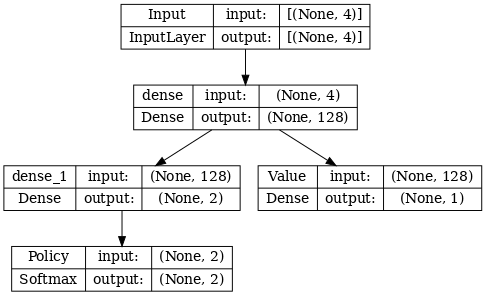

In [4]:
tf.keras.utils.plot_model(model, to_file="/tmp/model.png", show_shapes=True, dpi=70)

<center>Train Model</center>

In [ ]:
%%time

agent = ActorCritic(actor, critic, learning_rate=0.005, discount_factor=0.9)

def shaped_reward(reward, observation):
    position, pos_vel, angle, angle_vel = observation
    #return (1 - tf.abs(angle))
    return 1 - 0.5 * tf.abs(position) - 0.5 * tf.abs(angle)

state_bounds = np.array([2.4, 2.5, 0.21, 2.5]).astype(np.float32)
    
agent, total_rewards, episode_lengths = train_agent(env, agent, shaped_reward,
                                                    500, 5000, state_bounds,
                                                    (475, 100), True)

Episode: 1034, Steps: 263, Average Episode Length: 234.1

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

def smooth(s, alpha=0.2):
    averaging_length = int(len(s)*alpha)
    s = np.pad(s, (averaging_length//2, averaging_length//2), mode='edge')
    return np.convolve(s, np.ones(averaging_length)/averaging_length, mode='valid')

labels = ['Total Reward', 'Average Reward', 'Cumulative Reward', 'Episode Length']
data = [total_rewards, np.array(total_rewards) / episode_lengths, np.cumsum(total_rewards), episode_lengths]

for ax, label, data in zip(axes.flat, labels, data):
    ax.set_xlabel('Episode')
    ax.set_ylabel(label)
    ax.plot(data)
    if label != 'Cumulative Reward': ax.plot(smooth(data), '--')

fig.tight_layout()
plt.show()

In [ ]:
from pyvirtualdisplay import *
vdisp = Display(visible=0, size=(500, 500)).start()

def action_fn(env, observation):
    observation = observation / state_bounds
    prediction = agent.actor(observation[None, :])
    action = tf.random.categorical(tf.math.log(prediction), num_samples=1)
    return tf.squeeze(action).numpy()

env = gym.make('CartPole-v1')
frames = render(env, action_fn, 500)
env.close()

HTML(animation(frames, len(frames)/24e-3).to_html5_video())

In [ ]:
import time, os

timestamp = time.strftime("%Y.%m.%d-%H.%M")
os.mkdir(f'./AC{timestamp}')
print(f'./AC{timestamp}')

results = {"Total Reward":total_rewards, "Episode Length": episode_lengths}
np.save(f'./AC{timestamp}/results.npy', results)
agent.actor.save(f'./AC{timestamp}/actor.keras')
agent.critic.save(f'./AC{timestamp}/critic.keras')